In [1]:
machine = 'mac'
#machine = 'magny'

In [2]:
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
    filedir = "/home/extmilan/masterthesis/files/"
    plotdir = "/home/extmilan/masterthesis/plots/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
    filedir = "/Users/smilanov/Documents/masterthesis/auriga_files/files/"
    plotdir = "/Users/smilanov/Documents/masterthesis/auriga_files/plots/"
    
#file = filedir + 'potential_params_10000_with_initeqbestfit.txt'

#dopotfit = True

In [3]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014
from galpy.potential import evaluatePotentials, MiyamotoNagaiPotential, NFWPotential, HernquistPotential


from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import emcee

import numpy as np

from scipy import optimize as opt
from scipy import integrate

from astropy import units

from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind

from auriga_basics import *
from auriga_functions import *
from decomposition import *


import datetime
import random

%matplotlib inline

  Referenced from: /Users/smilanov/anaconda3/lib/python3.6/site-packages/galpy_interppotential_c.cpython-36m-darwin.so
  Reason: image not found' 


Build the potential
---
- Disk: Miyamoto Nagai (http://adsabs.harvard.edu/abs/1975PASJ...27..533M 
- Spheroid: Hernquist (http://adsabs.harvard.edu/abs/1990ApJ...356..359H)
- Halo: NFW (http://iopscience.iop.org/article/10.1086/304888/pdf)

$v_{circ} = \sqrt{R\frac{\partial\Phi}{\partial R}}$

Miyamoto Nagai potential
--

$\Phi_{MN} (R,z) = -\frac{GM}{\sqrt{R^2 + \left(a + \sqrt{z^2 + b^2}\right)^2}}$

$\rho_{MN} (R,z) = \frac{b^2M}{4\pi}
\frac{aR^2 + \left(a + 3\sqrt{z^2 + b^2}\right)\left(a + \sqrt{z^2 + b^2}\right)^2}
{\left[R^2 + \left(a + \sqrt{z^2 + b^2}\right)^2\right]^{5/2}\left(z^2 + b^2\right)^{3/2}}$

$
v_{circ_{MN}}(R,z)     = R \sqrt{
\frac
{ GM }
{ \left(R^2 + \left(a + \sqrt{z^2+b^2}\right)^2\right)^{3/2} }
}
$

Hernquist potential
--
$\Phi_H(r) = -\frac
{GM}
{r+a}
$

$\rho_H(r) = \frac{M}{2\pi}\frac{r}{a}\frac{1}{\left(r+a\right)^3}
$

$M_H(r) = M \frac{r^2}{(r+a)^2}$

$v_{circ_H}(r) = \frac
{\sqrt{GMr} }
{r+a} 
= \sqrt{\frac{GM(<r)}{r}}
$
    last equation part only valid in spherical symmetric systems
    
NFW potential 
--

1. fit MND and HB
2. calculate their circular velocities
3. calculate total velocity and get circular velocity of NFW by subtracting: $v_{circ_{NFW}} = \sqrt{v_{circ_{tot}}^2 - v_{circ_{MND}}^2 - v_{circ_{HB}}^2}$
4. setup galpy potential with fixed MND and HB with fitted vals and just fit NFW parameters to pot vals
5. (possible check: fit also v0 of NFW and compare to 'real' one)



In [4]:
#calculate density of disk
gal24 = decomposition(machine = machine)
gal24_z_kpc = gal24.z_kpc
z_median = np.median(np.abs(gal24_z_kpc))
disk_dens_data = gal24.voldens_data(N = 25, z_kpc = 0.5, R_kpc = None)


Load snapshot.
level   : 4
halo	: 24
snapnr  : 127
basedir : /Users/smilanov/Desktop/Auriga/level4/
halodir : /Users/smilanov/Desktop/Auriga/level4/halo_24/
snappath: /Users/smilanov/Desktop/Auriga/level4/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]

Carry out decomposition.
computing star properties
computing histograms
Calculate disk indices.
Calculate spheroid indices.
Load positions and masses of simulation data.
computing star properties
computing histograms
Import galpy parameters.
Setup galpy potential.


In [5]:
def voldens_galpy(xdata, a_MND_kpc, b_MND_kpc):
    fix_z = True 
    fix_R = False 
    use_masses = True 
    use_n = False    
    R_kpc = xdata[0]
    z_kpc = xdata[1]
    mass_10Msun = xdata[2]
    disk = MiyamotoNagaiPotential(amp = mass_10Msun *1e10 *u.Msun, a=a_MND_kpc * u.kpc, b=b_MND_kpc * u.kpc)
    if fix_z == True:
        voldens_bestfit = np.zeros(len(R_kpc))
        if use_masses == True:
            for i, item in enumerate(R_kpc):
                voldens_bestfit[i] = disk.dens(item * u.kpc, z_kpc * u.kpc) 
        elif use_n == True:
            for i, item in enumerate(R_kpc):
                item_galpy = item / self.R0_kpc
                z_fix_galpy = z_kpc / self.R0_kpc
                voldens_bestfit[i] = self.disk.dens(item_galpy, z_fix_galpy) * bovy_conversion.dens_in_msolpc3(self.v0_tot_kms, self.R0_kpc)

    elif fix_R == True:
        voldens_bestfit = np.zeros(len(z_kpc))
        if use_masses == True:
            for i, item in enumerate(z_kpc):
                voldens_bestfit[i] = self.disk.dens(R_kpc * u.kpc, item * u.kpc) 
        elif use_n == True:
            for i, item in enumerate(z_kpc):
                item_galpy = item / self.R0_kpc
                R_fix_galpy = R_kpc / self.R0_kpc
                voldens_bestfit[i] = self.disk.dens(R_fix_galpy, item_galpy) * bovy_conversion.dens_in_msolpc3(self.v0_tot_kms, self.R0_kpc)

    return(voldens_bestfit)

In [18]:
z_median

0.74540615

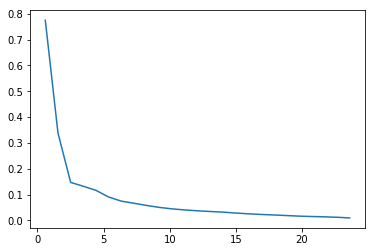

In [29]:
disk_mass_10_Msun = np.sum(gal24.s.mass[gal24.i_disk][gal24.i_r_in])
xdata = np.array([disk_dens_data[1], 0., disk_mass_10_Msun])
rhodata = disk_dens_data[0]
plt.plot(disk_dens_data[1], disk_dens_data[0])
bounds = ([0., 0.],[np.inf, np.inf])
popt, pcov = opt.curve_fit(voldens_galpy, xdata, rhodata, bounds=bounds)

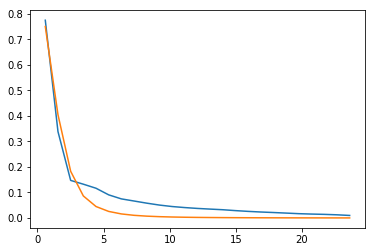

In [30]:
MNdisk_bestfit = MiyamotoNagaiPotential(amp = disk_mass_10_Msun * 1e10 * u.Msun, a=popt[0]*u.kpc, b=popt[1]*u.kpc)
MNdisk_dens_bestfit = MNdisk_bestfit.dens(disk_dens_data[1]*u.kpc, 0.*u.kpc)
plt.plot(disk_dens_data[1], disk_dens_data[0])

plt.plot(disk_dens_data[1], MNdisk_dens_bestfit)

In [8]:
opt.curve_fit?


In [9]:
MiyamotoNagaiPotential?

In [31]:
popt

array([ 1.46883517,  0.91468317])

In [11]:
### fit disk

# try to integrate numerically for poisson process
# take eq 2.69b (w/o mass) B&T08
# if that does not work fit to binned densities


## PART FOR THE LIKELIHOOD
Rmin_kpc = 1.
Rmax_kpc = 10.

def rho_MND(R_kpc, z_kpc, phi, a_kpc = 5., b_kpc = 1., specific = True, mass_10Msun = None):
    """
    INPUT:
        R_kpc, z_kpc: 
    """
    #a_kpc = args[0]
    #b_kpc = args[1]
    if specific == True:
        first_fac_kpc2 = b_kpc**2 / (4. * np.pi)
    else:
        first_fac_kpc2 = (mass_10Msun * b_kpc**2) / (4. * np.pi) # * 10^10M_sun
    bzsqrt_kpc = np.sqrt(z_kpc**2 + b_kpc**2)
    abz_sqrt_kpc = (a_kpc + bzsqrt_kpc)
    numerator_kpc3 = a_kpc * R_kpc**2 + (a_kpc + 3. * bzsqrt_kpc) * abz_sqrt_kpc**2
    denominator_kpc8 = (R_kpc**2 + abz_sqrt_kpc**2)**(5./2.) * bzsqrt_kpc**3
    rho_kpc_3 = first_fac_kpc2 * numerator_kpc3 / denominator_kpc8 # * 10^10 M_sun if not specific density
    return (rho_kpc_3)

'''    
def prob_MND(Rs, zs, a_kpc, b_kpc, Rmin_kpc, Rmax_kpc):
    res, res_err = integrate.tplquad(rho_MND, 0., 2. * np.pi, lambda phi: -np.inf, lambda phi: np.inf,
                  lambda phi, z_kpc: Rmin_kpc, lambda phi, z_kpc: Rmax_kpc, args = (a_kpc, b_kpc))
    rho = rho_MND(Rs, zs, a_kpc, b_kpc)
    p = rho / res
    return(p)

def likelihood_MND(Rs, zs, a_kpc, b_kpc, Rmin_kpc, Rmax_kpc):
    p = prob_MND(Rs, zs, a_kpc, b_kpc, Rmin_kpc, Rmax_kpc)
    logL = np.sum(np.log10(p))
    return logL

#_____function for scipy.differential_evolution that sums the relative error squares_____
def log_MND_scipydifferentialevolution(x, *args):
    
    # read fitting parameters:
    a_MND_kpc  = x[0]
    b_MND_kpc  = x[1]
    
    # read data:
    R_kpc_data    = args[0]
    z_kpc_data    = args[1]
    _REFR0_kpc    = args[2]
    Rmin_kpc      = args[3]
    Rmax_kpc      = args[4]
    
    logL_MND = likelihood_MND(R_kpc_data, z_kpc_data, a_MND_kpc, b_MND_kpc, Rmin_kpc, Rmax_kpc)
    #print(a_MND_kpc)
    #print(logL_MND)
    return (logL_MND)
'''
'''
def fit_MND(R_kpc_data, z_kpc_data, _REFR0_kpc = 8., Rmin_kpc = 1., Rmax_kpc = 10.):
    lower_floor = 1e-3
    bounds = ((lower_floor, 50.),  # a_MND
              (lower_floor, 10.))  # b_MND
              
    #fitting:
    res = opt.differential_evolution(
                log_MND_scipydifferentialevolution,
                bounds = bounds,
                args = (R_kpc_data, z_kpc_data, _REFR0_kpc, Rmin_kpc, Rmax_kpc),
                strategy = 'best1bin',
                maxiter = 1000, tol=0.01, atol=1e-7,
                disp = False
                )

    a_MND_kpc_bestfit  = res.x[0]
    b_MND_kpc_bestfit  = res.x[1]
    return(a_MND_kpc_bestfit, b_MND_kpc_bestfit)
'''

## PART FOR THE FIT TO THE DENSITY
def disk_dens(R_kpc, z_kpc, dR_kpc, dz_kpc, M_10Msun): 
    
    Rmin_kpc, Rmax_kpc = np.min(R_kpc), np.max(R_kpc)
    zmin_kpc, zmax_kpc = np.min(z_kpc), np.max(z_kpc)
    
    Rbins, zbins = np.arange(Rmin_kpc, Rmax_kpc, dR_kpc), np.arange(zmin_kpc, zmax_kpc, dz_kpc)
    mbins, volbins = np.zeros((len(zbins), len(Rbins))), np.zeros((len(zbins), len(Rbins))) 
    for i in range(len(zbins)):
        for j in range(len(Rbins)):
            inbin = (Rbins[j] <= R_kpc) & (R_kpc < (Rbins[j] + dR_kpc)) & (zbins[i] <= z_kpc) & (z_kpc < (zbins[i] + dz_kpc))
            mbins[i,j] = np.sum(M_10Msun[inbin])
            volbins[i,j] = np.pi * dz_kpc * (2. * Rbins[j] * dR_kpc + dR_kpc**2)
       
    rho = mbins / volbins
    return(rho, Rbins, zbins)    

def MNdens(x, a_kpc, b_kpc):
    '''
    INPUT: 
        x: R_kpc, z_kpc, Mass_tot
    '''
    R_kpc, z_kpc, mass_10Msun = x[0], x[1], x[2]
    first_fac_kpc2 = (mass_10Msun * b_kpc**2) / (4. * np.pi) # * 10^10M_sun
    bzsqrt_kpc = np.sqrt(z_kpc**2 + b_kpc**2)
    abz_sqrt_kpc = (a_kpc + bzsqrt_kpc)
    numerator_kpc3 = a_kpc * R_kpc**2 + (a_kpc + 3. * bzsqrt_kpc) * abz_sqrt_kpc**2
    denominator_kpc8 = (R_kpc**2 + abz_sqrt_kpc**2)**(5./2.) * bzsqrt_kpc**3
    rho_kpc_3 = first_fac_kpc2 * numerator_kpc3 / denominator_kpc8 # * 10^10 M_sun if not specific density
    return(rho_kpc_3)


def fit_dens_MND(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun):
    rho_data, R_data, z_data = disk_dens(R_kpc, z_kpc, dR_kpc, dz_kpc, M_diskstars_10Msun)
    
    side_x = R_data
    side_y = z_data
    X1, X2 = np.meshgrid(side_x, side_y)
    size = X1.shape
    x1_1d = X1.reshape((1, np.prod(size)))
    x2_1d = X2.reshape((1, np.prod(size)))
    size2 = x1_1d.shape
    x3_1d = np.repeat(M_tot_disk_stars_10Msun, size2[1])
    x3_1d = x3_1d.reshape((size2))
    xdata = np.vstack((x1_1d, x2_1d, x3_1d))
    z = rho_data
    Z = z.reshape(size2[1])
    ydata = Z
    popt, pcov = opt.curve_fit(MNdens, xdata, ydata)
    z_fit = MNdens(xdata, *popt)
    Z_fit = z_fit.reshape(size)

    plt.subplot(1, 2, 1)
    plt.title("Real Function")
    plt.pcolormesh(X1, X2, z, norm=LogNorm(), cmap=plt.get_cmap('plasma'))
    plt.axis('equal')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title("Fitted Function")
    plt.pcolormesh(X1, X2, Z_fit, norm=LogNorm(), cmap=plt.get_cmap('plasma'))
    plt.axis('equal')
    plt.colorbar()
    plt.tight_layout()

    plt.show()
    return(popt)
    
    
def v_circ_MND_func(R_kpc_data, z_kpc_data, M_tot_10Msun, R0_kpc, z0_kpc = 0.):
    a_MND_kpc, b_MND_kpc = fit_MND(R_kpc_data, z_kpc_data, _REFR0_kpc = R0_kpc)
    denom = (R0_kpc**2 + (a_MND_kpc + np.sqrt(z0_kpc**2 + b_MND_kpc**2))**2)**(3./2.)
    v_circ = R0_kpc * np.sqrt(43.01e3* M_tot_10Msun / denom)
    return(a_MND_kpc, b_MND_kpc, v_circ)

def v_circ_MND_ab(R_kpc, z_kpc, a_MND_kpc, b_MND_kpc, M_tot_10Msun):
    denom = (R_kpc**2 + (a_MND_kpc + np.sqrt(z_kpc**2 + b_MND_kpc**2))**2)**(3./2.)
    v_circ = R_kpc * np.sqrt(43.01e3* M_tot_10Msun / denom)
    return(v_circ)

def v_circ_MND_dens_func(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun, R0_kpc, z0_kpc):
    a_MND_kpc, b_MND_kpc = fit_dens_MND(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun)
    denom = (R0_kpc**2 + (a_MND_kpc + np.sqrt(z0_kpc**2 + b_MND_kpc**2))**2)**(3./2.)
    v_circ = R0_kpc * np.sqrt(43.01e3* M_tot_disk_stars_10Msun / denom)
    return(a_MND_kpc, b_MND_kpc, v_circ)

def MND(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun, R0_kpc, z0_kpc = 0.):
    print('Start MND fit at', datetime.datetime.now().time())
    a_MND_kpc, b_MND_kpc, v_circ = v_circ_MND_dens_func(R_kpc, z_kpc, dR_kpc, dz_kpc, M_tot_disk_stars_10Msun, M_diskstars_10Msun, R0_kpc, z0_kpc = 0.)
    print('MND: a[kpc], b[kpc], vcirc [km/s]:', a_MND_kpc, b_MND_kpc, v_circ)
    return(a_MND_kpc, b_MND_kpc, v_circ)

In [12]:
### fit bulge

def rho_data(M_stars_10Msun, r_kpc, dr_kpc, log = True):
    
    rmin_kpc, rmax_kpc = np.min(r_kpc), np.max(r_kpc)

    rbins_kpc = np.arange(rmin_kpc, rmax_kpc, dr_kpc)
    rbins_log_kpc = np.logspace(np.log10(rmin_kpc), np.log10(rmax_kpc), 97)
    mbins_10Msun = np.zeros(len(rbins_kpc))
    volbins_kpc3 = np.zeros(len(rbins_kpc))
    if log == False:
        for i in range(len(rbins_kpc)):
            inbin = (rbins_kpc[i] <= r_kpc) & (r_kpc < (rbins_kpc[i] + dr_kpc)) # spherical shells
            mbins_10Msun[i] = np.sum(M_stars_10Msun[inbin])
            volbins_kpc3[i] = 4./3. * np.pi * dr_kpc * (3. * rbins_kpc[i]**2 + 3. * rbins_kpc[i] * dr_kpc + dr_kpc**2)
    elif log == True:
        mbins_10Msun = np.zeros(len(rbins_log_kpc))
        volbins_kpc3 = np.zeros(len(rbins_log_kpc))
        dr_log_kpc = np.log(rbins_log_kpc[1]/rbins_log_kpc[0])
        for i in range(len(rbins_log_kpc)):
            inbin = (rbins_log_kpc[i] <= r_kpc) & (r_kpc < (rbins_log_kpc[i] + dr_log_kpc)) # spherical shells
            mbins_10Msun[i] = np.sum(M_stars_10Msun[inbin])
            volbins_kpc3[i] = 4./3. * np.pi * dr_log_kpc * (3. * rbins_log_kpc[i]**2 + 3. * rbins_log_kpc[i] * dr_log_kpc + dr_log_kpc**2)

        
    rho_10Msun_kpc3 = mbins_10Msun / volbins_kpc3
    return(rho_10Msun_kpc3, rbins_log_kpc)

'''
def HB(v0_kms, a_HB_kpc, r_kpc, z_kpc, _REFR0_kpc, normalize = True):
    HB = HernquistPotential(a_HB_kpc, normalize=normalize)
    rho_model_galpy = evaluateDensities(HB, r_kpc, z_kpc) 
    rho_model_10Msun_kpc3 = rho_model_galpy * bovy_conversion.dens_in_msolpc3(v0_kms, _REFR0_kpc) * 10.
    return(rho_model_10Msun_kpc3)
'''


def Hernquistdens(r_kpc, a_HB_kpc, amp_10Msun):
    rho_10Msun_kpc3 = amp_10Msun / (4. * np.pi * a_HB_kpc**3.) * (1. / ((r_kpc / a_HB_kpc) * (1. + r_kpc / a_HB_kpc)**3))
    return(np.log(rho_10Msun_kpc3))
    
def fit_HB(M_stars_10Msun, r_kpc, dr_kpc):
    rho_data_10Msun_kpc3, rbins_kpc = rho_data(M_stars_10Msun, r_kpc, dr_kpc)
    #print(rbins_kpc)
    rho_data_10Msun_kpc3 = np.log(rho_data_10Msun_kpc3)
    plt.plot(rbins_kpc, rho_data_10Msun_kpc3, 'r.')
    plt.xlabel('r[kpc]')
    plt.ylabel('rho [10^10Msun/kpc^3]')
    #print(rho_data_10Msun_kpc3, rbins_kpc)
    #print(rho_data_10Msun_kpc3)
    rho_data_10Msun_kpc3 = np.where(np.isinf(rho_data_10Msun_kpc3), rho_data_10Msun_kpc3[-2] ,rho_data_10Msun_kpc3)
    #print(rho_data_10Msun_kpc3)
    popt, pcov = opt.curve_fit(Hernquistdens, rbins_kpc, rho_data_10Msun_kpc3)
    a_HB_kpc = popt[0]
    plt.plot(rbins_kpc, Hernquistdens(rbins_kpc, popt[0], popt[1]))
    plt.show()
    return(a_HB_kpc)

def v_circ_HB_func(M_stars_10Msun, r_kpc, dr_kpc, r0_kpc):
    a_HB_kpc = fit_HB(M_stars_10Msun, r_kpc, dr_kpc)
    M_tot_10Msun = np.sum(M_stars_10Msun)
    vcirc = np.sqrt(43.01e3* M_tot_10Msun * r0_kpc)/ (r0_kpc + a_HB_kpc)
    #vcirc = np.sqrt(43.01e3 * M_enc / r_kpc)
    return(a_HB_kpc, vcirc)

def v_circ_HB_func_justr(r_kpc, a_HB_kpc, M_tot_10Msun):
    vcirc = np.sqrt(43.01e3* M_tot_10Msun * r_kpc)/ (r_kpc + a_HB_kpc)
    return(vcirc)
    
def v_circ_HB_a(r_kpc_spher, M_spher_10Msun):#, a_HB_kpc, M_stars_10Msun):
    """
    INPUT:
    """
    #M_tot_10Msun = np.sum(M_stars_10Msun)
    #vcirc = np.sqrt(43.01e3* M_tot_10Msun * r_kpc)/ (r_kpc + a_HB_kpc)

    r_kpc = np.linspace(np.min(r_kpc_spher), np.max(r_kpc_spher), 25)
    v_circ_shell = np.zeros(len(r_kpc))
    for i, item in enumerate(r_kpc):
        mass_mask = np.where((r_kpc_spher<=item))
        mass_10Msun  = np.sum(M_spher_10Msun[mass_mask])
        v_circ_shell[i] = np.sqrt(43.01e3 * mass_10Msun / item)
    return(v_circ_shell)

def HB(M_stars_10Msun, r_kpc, dr_kpc, r0_kpc):
    print('Start HB fit at', datetime.datetime.now().time())
    a_HB_kpc, vcirc = v_circ_HB_func(M_stars_10Msun, r_kpc, dr_kpc, r0_kpc)
    print('HB: a[kpc], vcirc [km/s]:', a_HB_kpc, vcirc)
    return(a_HB_kpc, vcirc)

def HB2(r_kpc_spher, M_spher_10Msun):
    vcirc = v_circ_HB_a(r_kpc_spher, M_spher_10Msun)
    return(vcirc)

$v_{circ_{tot}} = \sqrt{\frac{GM(<R_0)}{R_0}} $

$G = 43.0071 \cdot 10^{3} \frac{kpc}{10^{10} M_\odot}\frac{km^2}{s^2}$

In [13]:
def v_circ_tot_func(r_kpc):
    try:
        test = len(r_kpc)
        types = ( s.type == 0) + (s.type == 1) + (s.type == 2) + (s.type == 3) + (s.type == 4)

        #mass_mask    = np.zeros(len(r_kpc))
        #mass_10Msun  = np.zeros(len(r_kpc))
        v_circ_shell = np.zeros(len(r_kpc))

        for i, item in enumerate(r_kpc):
            mass_mask    = np.where( (types) & (s.halo == 0) & ((1000. * s.r()) < (item)))
            mass_10Msun  = np.sum(s.mass[mass_mask])
            v_circ_shell[i] = np.sqrt(43.01e3 * mass_10Msun / item)

        v_circ =  v_circ_shell
    except:
        mass_10Msun = np.sum(s.mass[((1000. * s.r()) <= r_kpc) ] )
        v_circ = np.sqrt(43.01e3 * mass_10Msun / r_kpc)
        
    return(v_circ)

In [14]:
### fit halo (variably)

def v_circ_NFW_func(r_kpc, v_circ_MND, v_circ_HB, v_circ_tot = None):
    try:
        if v_circ_tot == None:
            v_circ_tot = v_circ_tot_func(r_kpc)
    except ValueError:
        pass
        #continue

    v_circ_NFW = np.sqrt(v_circ_tot**2 - v_circ_MND**2 - v_circ_HB**2) #could be negative! then its nan vals
    return(v_circ_NFW)


In [15]:
#_____function that sets-up galpy potential_____
def setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc):
    
    #test input:
    if (a_MND_kpc <= 0.) or (b_MND_kpc <= 0.) or (a_NFWH_kpc <= 0.) or (a_HB_kpc <= 0.) \
       or (n_MND <= 0.) or (n_NFWH <= 0.) or (n_HB <= 0.) or (n_MND >= 1.) or (n_NFWH >= 1.) or (n_HB >= 1.):
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The input parameters for the scaling profiles do not correspond to a physical potential.')
    if np.fabs(n_MND + n_NFWH + n_HB - 1.) > 1e-7:
        raise ValueError('Error in setup_galpy_potential: '+\
                         'The sum of the normalization does not add up to 1.')
        
    #trafo to galpy units:
    a_MND  = a_MND_kpc  / _REFR0_kpc
    b_MND  = b_MND_kpc  / _REFR0_kpc
    a_NFWH = a_NFWH_kpc / _REFR0_kpc
    a_HB   = a_HB_kpc   / _REFR0_kpc
    
    #setup potential:
    disk = MiyamotoNagaiPotential(
                a = a_MND,
                b = b_MND,
                normalize = n_MND)
    halo = NFWPotential(
                a = a_NFWH,
                normalize = n_NFWH)
    bulge = HernquistPotential(
                a = a_HB,
                normalize = n_HB) 
     
    return [disk,halo,bulge]


In [16]:
#_____function for scipy.differential_evolution that sums the relative error squares_____
def rel_pot_error_scipydifferentialevolution(x,*args):
    
    # read fitting parameters:
    v0_tot_kms = x[0]
    a_NFWH_kpc = x[1]
        
    
    # read data:
    
    a_MND_kpc     = args[0]
    b_MND_kpc     = args[1]
    a_HB_kpc      = args[2]    
    v0_MND_kms    = args[3]
    v0_HB_kms     = args[4]
    R_kpc_data    = args[5]
    z_kpc_data    = args[6]
    pot_kms2_data = args[7]
    _REFR0_kpc    = args[8]
    
    
    v0_NFWH_kms = np.sqrt(v0_tot_kms**2 - v0_HB_kms**2 - v0_MND_kms**2)
    
    n_NFWH = v0_NFWH_kms**2 / v0_tot_kms**2
    n_HB   = v0_HB_kms**2   / v0_tot_kms**2
    n_MND  = v0_MND_kms**2  / v0_tot_kms**2
    # setup potential (and check if parameters are physical):
    try:
        pot_galpy_model = setup_galpy_potential(a_MND_kpc, b_MND_kpc, a_NFWH_kpc, a_HB_kpc, n_MND, n_NFWH, n_HB, _REFR0_kpc)
    except Exception as e:
        return np.inf

    # calculate potential values at (R,z) for this potential:
    #print(R_kpc_data)
    #print(z_kpc_data)
    #print(_REFR0_kpc)
    #print(v0_tot_kms)
    pot_kms2_model = evaluatePotentials(pot_galpy_model,
                                   R_kpc_data / _REFR0_kpc,
                                   z_kpc_data / _REFR0_kpc) * (v0_tot_kms)**2
    
    #calculate sum of relative error squares:
    err = np.sum(((pot_kms2_data - pot_kms2_model) / pot_kms2_model)**2)
    return err

In [17]:
### get everything together somehow 

level = 4
startsnap = 60
endsnap = 128

#j = 0

for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(startsnap,endsnap,1):
        print("snapnr  : {0}".format(snapnr))
        print(datetime.datetime.now().time())
        try:
            s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[1,2,3,4], 
            haloid=0, galradfac=0.1, verbose=True)    
        except KeyError:
            print('\n\n', snapnr, 'not read in.\n\n')
            continue
            
        try: 
            # Clean negative and zero values of gmet to avoid RuntimeErrors
            # later on (e.g. dividing by zero)
            s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
        except:
            continue

            
        
        R0_kpc = 1000. * 1./3. * s.galrad
        z0_kpc = 0.
        r0_kpc = R0_kpc
        dr_kpc = 0.5
        
        disk_ID, spheroid_ID, bulge_ID, halo_ID = decomp(s, r_cutoff_Mpc = 0.05, Gcosmo = 43.01, plotter = True, disccirc_min = 0.7, disccirc_max = 1.7)
        
        ## get data from simulations

        i_stars = np.where( (s.halo == 0) & (s.type == 4) & (s.r() <= s.galrad) & (s.r() > 0.) )
        #j = np.where( s.data[i_stars]['age'] > 0. )
        #i_stars = i_stars[j]
        i_spheroid = np.isin(s.id, spheroid_ID)
        i_disk = np.isin(s.id, disk_ID)
        i_dm = np.where( (s.halo == 0) & ((s.type == 1) + (s.type == 2) + (s.type == 3)) )
        
        galrad_kpc = 1000. * s.galrad
        
        # choice of R_kpc_data and z_kpc_data
        (x_kpc, y_kpc, z_kpc), (vx_kpc, vy_kpc, vz_kpc), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, i_stars)
        (R_kpc, phi, z_kpc), (vR_kms, vphi_kms, vz_kms) = get_cylindrical_vectors(s, sf, i_stars)
        #print('istars', len(i_stars[0]), 'idisk', np.sum(i_disk), 'i_spher', np.sum(i_spheroid))

        (x_kpc_disk, y_kpc_disk, z_kpc_disk), (vx_kpc_disk, vy_kpc_disk, vz_kpc_disk), rxyz_kpc_disk, rxy_kpc_disk = get_cartesian_vectors(s, sf, i_disk)
        (R_kpc_disk, phi_disk, z_kpc_disk), (vR_kms_disk, vphi_kms_disk, vz_kms_disk) = get_cylindrical_vectors(s, sf, i_disk)
        
        (x_kpc_spher, y_kpc_spher, z_kpc_spher), (vx_kpc_spher, vy_kpc_spher, vz_kpc_spher), rxyz_kpc_spher, rxy_kpc_spher = get_cartesian_vectors(s, sf, i_spheroid)
        (R_kpc_spher, phi_spher, z_kpc_spher), (vR_kms_spher, vphi_kms_spher, vz_kms_spher) = get_cylindrical_vectors(s, sf, i_spheroid)

        
        #R_kpc_data = R_kpc[i_disk][i_stars]
        #z_kpc_data = z_kpc[i_disk][i_stars]
        r_kpc_spher = 1000. * s.r()[i_spheroid]
        #print(np.max(r_kpc))
        
        plt.hist2d(R_kpc_disk, z_kpc_disk, 41, norm=LogNorm())
        plt.colorbar()
        plt.axis('equal')
        plt.show()
        plt.hist2d(x_kpc_disk, y_kpc_disk, 41, norm=LogNorm())
        plt.axis('equal')
        plt.colorbar()
        plt.show()        
        
        plt.hist2d(R_kpc_spher, z_kpc_spher, 41, norm=LogNorm())
        plt.axis('equal')
        plt.colorbar()
        plt.show()
        plt.hist2d(x_kpc_spher, y_kpc_spher, 41, norm=LogNorm())
        plt.axis('equal')
        plt.colorbar()
        plt.show()
        
        M_disk_10Msun = s.mass[i_disk]
        M_disk_tot_10Msun = np.sum(s.mass[i_disk])
        M_spher_10Msun = s.mass[i_spheroid]
        
        r_kpc_binned = np.linspace(np.min(r_kpc_spher), np.max(r_kpc_spher), 25)
        #print(r_kpc_binned)
        
        ## fit single parts
        res1 = MND(R_kpc_disk, z_kpc_disk, dR_kpc = 0.5, dz_kpc = 1., M_tot_disk_stars_10Msun = M_disk_tot_10Msun, M_diskstars_10Msun = M_disk_10Msun, R0_kpc = R0_kpc, z0_kpc = 0.)
        a_MND_kpc, b_MND_kpc, v_circ_MND = res1
        res = fit_dens_MND(R_kpc_disk, z_kpc_disk, dR_kpc = 0.5, dz_kpc = 1., M_tot_disk_stars_10Msun = M_disk_tot_10Msun, M_diskstars_10Msun = M_disk_10Msun)
        #a_MND_kpc, b_MND_kpc, v_circ_MND = MND(R_kpc_data[i_disk], z_kpc_data[i_disk], M_stars_tot_10Msun, R0_kpc, z0_kpc = 0.)
        a_HB_kpc, v_circ_HB = HB(M_spher_10Msun, r_kpc_spher, dr_kpc, r0_kpc)
        v_circ_test1 = HB2(r_kpc_spher, M_spher_10Msun)
        v_circ_test2 = v_circ_HB_func_justr(r_kpc_binned, a_HB_kpc, np.sum(M_spher_10Msun))
        
        plt.plot(r_kpc_binned, v_circ_test1, 'r-', label = '$\sqrt{\\frac{GM(<r)}{r}}$')
        plt.plot(r_kpc_binned, v_circ_test2, 'g--', label = '$\\frac{\sqrt{GMr}}{r+a}$')
        plt.legend()
        plt.show()
        #rot curves
        
        
        #### GUESS OK WITH THE SPHEROID AND DISK FIT 
        
        r_kpc           = np.linspace(0, 1000. * s.galrad, 100)
        v_circ_disk     = v_circ_MND_ab(R_kpc=r_kpc, z_kpc=0., a_MND_kpc=a_MND_kpc, b_MND_kpc=b_MND_kpc, M_tot_10Msun=M_disk_tot_10Msun)
        v_circ_spheroid = v_circ_HB_func_justr(r_kpc, a_HB_kpc, np.sum(M_spher_10Msun))
        v_circ_tot      = v_circ_tot_func(r_kpc=r_kpc)
        v_circ_halo     = v_circ_NFW_func(r_kpc, v_circ_disk, v_circ_spheroid, v_circ_tot)

        v0_MND_kms = v_circ_MND_ab(R0_kpc, z0_kpc, a_MND_kpc=a_MND_kpc, b_MND_kpc=b_MND_kpc, M_tot_10Msun=M_disk_tot_10Msun)
        v0_HB_kms  = v_circ_HB_func_justr(R0_kpc, a_HB_kpc, np.sum(M_spher_10Msun))
        print(v0_MND_kms, v0_HB_kms)
        v0_circ_tot = v_circ_tot_func(r_kpc=R0_kpc)
        print('v0_circ_tot =', v0_circ_tot)
        
        plt.plot(r_kpc, v_circ_spheroid, 'b:', label = 'spheroid')
        plt.plot(r_kpc, v_circ_disk, 'g-.', label = 'disk')
        plt.plot(r_kpc, v_circ_halo, 'r--', label = 'halo')
        plt.plot(r_kpc, v_circ_tot, 'k-', label = 'total')
        plt.xlabel('R [kpc]')
        plt.ylabel('$v_{circ} \ [km/s]$')
        plt.legend()        
        plt.show()
        # calculate v_circ NFW
        #v_circ_NFW = v_circ_NFW_func(v_circ_MND, v_circ_HB, R0_kpc)
        #print(v_circ_NFW, v_circ_MND, v_circ_HB)
        #nn = 35
        #R0_ref = r_kpc[nn]
        #print(R0_ref)
        #v0_ref = v_circ_tot[nn]
        #n_NFW  = v_circ_halo[nn]** 2      / v_circ_tot[nn] **2
        #n_HB   = v_circ_spheroid[nn] ** 2 / v_circ_tot[nn] **2
        #n_MND  = v_circ_disk[nn] ** 2     / v_circ_tot[nn] **2
        #print(r_kpc[30], n_NFW + n_HB + n_MND )
        
        part_num = 50001
        
        i_dm, = np.where( (s.halo == 0) & (s.r() < s.galrad) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))


        r_kpc_dm = 1000. * s.r()[i_dm]
        (R_kpc_dm, phi_rad_dm, z_kpc_dm), (vR_kms_dm, vphi_kms_dm, vz_kms_dm) = get_cylindrical_vectors(s, sf, i_dm) 
        pot_kms2_dm = s.pot[i_dm]

        # draw random sample out of data
        try:
            rand_samp = np.array(random.sample(list(enumerate(pot_kms2_dm)), part_num))
            rand_ind = rand_samp[:,0].astype(int)
            pot_kms2_dm_data = rand_samp[:, 1]
            r_kpc_dm_data = r_kpc_dm[rand_ind]
            R_kpc_dm_data = R_kpc_dm[rand_ind]
            z_kpc_dm_data = z_kpc_dm[rand_ind]
        except ValueError:        
            pot_kms2_dm_data = pot_kms2_dm
            r_kpc_dm_data = r_kpc_dm
            R_kpc_dm_data = R_kpc_dm
            z_kpc_dm_data = z_kpc_dm
        lower_floor = 1e-3
        bounds = ((5./6. * v0_circ_tot, 400.), #REF_V0_kms
                 (lower_floor, 400.)) #a_NFWH
        args = (a_MND_kpc, b_MND_kpc, a_HB_kpc, v0_MND_kms, v0_HB_kms, R_kpc_dm_data, z_kpc_dm_data, pot_kms2_dm_data, R0_kpc)

        print(args)
        plt.hist2d(R_kpc_dm_data, z_kpc_dm_data, 21, norm=LogNorm())
        plt.axis('equal')
        plt.colorbar()
        plt.show()
        #plt.hist2d(x_kpc_spher, y_kpc_spher, 21, norm=LogNorm())
        #plt.axis('equal')
        #plt.colorbar()
        #plt.show()

        #fitting:
        res = opt.differential_evolution(
                    rel_pot_error_scipydifferentialevolution,
                    bounds=bounds,
                    args=args,#, MND, HB, NFWH),
                    strategy='best1bin',
                    maxiter=1000,tol=0.01,atol=1e-7,
                    disp=False
                    )
        

        v0_kms_bestfit     = res.x[0]
        a_NFWH_kpc_bestfit = res.x[1]
    
        
        v0_NFWH_kms = np.sqrt(v0_kms_bestfit**2 - v0_HB_kms**2 - v0_MND_kms**2)
        data_saved = np.array([snapnr, R0_kpc, v0_kms_bestfit, a_MND_kpc, b_MND_kpc, a_HB_kpc, a_NFWH_kpc_bestfit, v0_MND_kms, v0_HB_kms, v0_NFWH_kms])
        print(len(data_saved), np.shape(data_saved))
        print(data_saved)
        formt = '%3.12f'
        
        np.savetxt(filedir + 'potential_params/pot_snap_' + str(snapnr), data_saved, fmt = formt)
        print('Snapshot = ', snapnr)
        print('v0_tot_kms at R0_kpc =', R0_kpc, ':', v0_kms_bestfit)
        print('Stellar Disk - a_MND_kpc =', a_MND_kpc, 'b_MND_kpc =', b_MND_kpc, 'v0_MND_kms =', v0_MND_kms)
        print('Stellar Spheroid - a_HB_kp c=', a_HB_kpc, 'v0_HB_kms =', v0_HB_kms)
        print('DM Halo - a_NFWH_kpc =', a_NFWH_kpc_bestfit, 'v0_NFWH_kms =', v0_NFWH_kms)



snapnr  : 60
19:57:25.059966
No subfind data found for id=60, dir=/Users/smilanov/Desktop/Auriga/level4/halo_24/output/, base=fof_subhalo_tab_, file=/Users/smilanov/Desktop/Auriga/level4/halo_24/output/groups_060/fof_subhalo_tab_060.0.


Exception: Neither /Users/smilanov/Desktop/Auriga/level4/halo_24/output//snapshot_060 nor /Users/smilanov/Desktop/Auriga/level4/halo_24/output//snapshot_060.0 exists.

In [ ]:
v0_NFWH_kms = np.sqrt(v0_kms_bestfit**2 - v0_HB_kms**2 - v0_MND_kms**2)
print('v0_tot_kms at R0_kpc =', R0_kpc, ':', v0_kms_bestfit)
print('Stellar Disk - a_MND_kpc =', a_MND_kpc, 'b_MND_kpc =', b_MND_kpc, 'v0_MND_kms =', v0_MND_kms)
print('Stellar Spheroid - a_HB_kp c=', a_HB_kpc, 'v0_HB_kms =', v0_HB_kms)
print('DM Halo - a_NFWH_kpc =', a_NFWH_kpc_bestfit, 'v0_NFWH_kms =', v0_NFWH_kms)


In [ ]:
v0_NFWH_kms = np.sqrt(v0_kms_bestfit**2 - v0_HB_kms**2 - v0_MND_kms**2)
print('v0_tot_kms at R0_kpc =', R0_kpc, ':', v0_kms_bestfit)
print('Stellar Disk - a_MND_kpc:', a_MND_kpc, 'b_MND_kpc:', b_MND_kpc, 'v0_MND_kms:', v0_MND_kms)
print('Stellar Spheroid - a_HB_kpc:', a_HB_kpc, 'v0_HB_kms:', v0_HB_kms)
print('DM Halo - a_NFWH_kpc:', a_NFWH_kpc_bestfit, 'v0_NFWH_kms:', v0_NFWH_kms)


In [ ]:
n_NFW = v_circ_halo[35] ** 2 / v_circ_tot[35] **2
n_HB = v_circ_spheroid[35] ** 2 / v_circ_tot[35] **2
n_MND = v_circ_disk[35] ** 2 / v_circ_tot[35] **2
print(r_kpc[65], n_NFW + n_HB + n_MND )

In [ ]:

v_circ_NFW = v_circ_NFW_func(v_circ_MND, v_circ_HB, R0_kpc)
print(v_circ_NFW, v_circ_MND, v_circ_HB)
print(np.sqrt(v_circ_NFW**2 + v_circ_HB**2 + v_circ_MND**2))

In [ ]:
a_HB_kpc

In [ ]:
print(a_MND_kpc, b_MND_kpc, a_HB_kpc
     )

In [ ]:
plt.plot(r_kpc, v_circ_spheroid, 'k.', label = 'spheroid')
plt.plot(r_kpc, v_circ_disk, 'g-', label = 'disk')
plt.plot(r_kpc, v_circ_halo, 'r--', label = 'halo')
plt.plot(r_kpc, v_circ_tot, 'b-.', label = 'total')
plt.xlabel('R [kpc]')
plt.ylabel('$v_{circ} \ [km/s]$')
plt.legend()